<a href="https://colab.research.google.com/github/flow4u/nfu/blob/EraCORE-ISARIC/Sterftecijfers_Nederland_COVID_19_periode_vergelijken_met_eerdere_jaren.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deaths of the Netherlands

**The 'interesting tables and graphs' are all the way at the bottom.**
Unlike other tables and graphs, full disclosure on how the tables and graphs are created from which source and how the data was processed.

Most likely this Notebook will be updated every Friday around 15:00 CET. However, feel free to make a copy and run it by yourself.

*   **Source:** CBS Open data, no other data is used
*   **Note:** Everything is normalized to: deaths per 100.000 per week for the specific year
    * this makes comparison possible because it eliminates the problem of:
       * different number of weeks per year
       * because some years have 'broken' week for Week 52 or 53 (not full 7 days):
          * Rule 1: if Week 52 => Week 52 = Week 52 / #days *7
          * Rule 2: if Week 53 in year x and Week 0 in year x+1 => Week 53 = Week 53 + Week 0, Week 0 is deleted
          * Rule 3: If Week 53 in year x and Week 1 in year x+1 ==> Week 1 = Week 1 + Week 53, Week 53 is seleted
       * different population sizes
          * Population is calculated by interpolation of Population on 1/1 year x and Population 1/1 year x+1

## Setting things up

In [1]:
#@title
# installing the necessary libraries for this notebook
!pip install cbsodata
import cbsodata
import pandas as pd
import numpy as np
from datetime import timedelta, datetime
import matplotlib.pyplot as plt
from tabulate import tabulate
import seaborn as sns

In [2]:
#@title
# Defining the required global variables
## get current year
current_year = int(datetime.now().year)
next_year = str(datetime.now().year + 1)

# some graph settings
## style
plt.style.use('seaborn-darkgrid')

## create a color palette
palette = plt.get_cmap('Dark2_r')

## Getting CBS data




### Getting table 70895ned data

*   Perioden
*   Overledenen_1 (diseased)

Table 70895ned contains diseased from 1995 till now on weekly basis.

In [3]:
#@title
# get CBS data
filtering = "((Geslacht eq '1100')) and ((LeeftijdOp31December eq '10000'))"
selection = ['Perioden', 'Overledenen_1']
data = pd.DataFrame(cbsodata.get_data('70895ned',
                                      filters=filtering,
                                      select=selection))

# remove all non Jaar-Week
data = data[data['Perioden'].map(len) > 5]

# making Perioden usefull by splitting up in Jaar, Week, Gebroken
# Gebroken, most likely Week 53 and Week 1, or Week 53 and Week 0 are not full 7 days records
data['Jaar'] = [x[0:4] for x in data['Perioden']]
data['Gebroken'] = ['' if x.find('(') == -1 else x[x.find('('):] for x in data['Perioden']]
data['Week'] = [int(x[10:]) if x.find('(') == -1 else int(x[10:x.find('(') - 1]) for x in data['Perioden']]

# Fixing Gebroken
# Rule 1: if Week 52 then Week 52 = Week 52 / #days * 7
# Rule 2: if Week 0 then Week 53 = Week 53 + Week 0 next year
# Rule 3: if no Week 0 then Week 1 = Week 1 + Week 53 previous year
data.drop([0], inplace=True)
data.reset_index(drop=True, inplace=True)
item = 'Overledenen_1'
for i in range(len(data)):
    if data.loc[i, 'Week'] == 52 and data.loc[i, 'Gebroken'] != '':
      data.loc[i, item] = int((data.loc[i, item]/int(data.loc[i, 'Gebroken'][1:3])*7).round(0))
      data.loc[i, 'Gebroken'] = ''
    if data.loc[i, 'Week'] == 53 and data.loc[i, 'Gebroken'] != '':
        if data.loc[i+1, 'Week'] == 0:
            data.loc[i, item] = data.loc[i, item] + data.loc[i + 1, item]
            # when that week is fixed, remove make 'gebroken' empty
            data.loc[i, 'Gebroken'] = ''
        else:
            data.loc[i + 1, item] = data.loc[i + 1, item] + data.loc[i, item]
            # when that week is fixed, remove make 'gebroken' empty
            data.loc[i + 1, 'Gebroken'] = ''

# remove all 'Gebroken' - non-fixed
data = data[data['Gebroken'].map(len) < 2]
# reset the index
data.reset_index(drop=True, inplace=True)
# remove no longer needed columns
data.drop(['Gebroken', 'Perioden'], axis=1, inplace=True)

# Making sure Jaar is of right type
data['Jaar'] = data['Jaar'].astype('int')

# Setting the order of the dataframe
data = data[['Jaar', 'Week', 'Overledenen_1']]

# Copy data into df_overledenen_1995_current and print table
df_70895ned = data.copy()
df_70895ned['Week'].astype('int')
df_70895ned['Jaar'].astype('int')
print(tabulate(df_70895ned, headers=['Jaar', 'Week', 'Overledenen_1'], tablefmt='orgtbl', showindex=False))

|   Jaar |   Week |   Overledenen_1 |
|--------+--------+-----------------|
|   1995 |      1 |            2719 |
|   1995 |      2 |            2823 |
|   1995 |      3 |            2609 |
|   1995 |      4 |            2664 |
|   1995 |      5 |            2577 |
|   1995 |      6 |            2536 |
|   1995 |      7 |            2551 |
|   1995 |      8 |            2510 |
|   1995 |      9 |            2490 |
|   1995 |     10 |            2770 |
|   1995 |     11 |            2800 |
|   1995 |     12 |            2786 |
|   1995 |     13 |            2634 |
|   1995 |     14 |            2717 |
|   1995 |     15 |            2645 |
|   1995 |     16 |            2691 |
|   1995 |     17 |            2645 |
|   1995 |     18 |            2628 |
|   1995 |     19 |            2486 |
|   1995 |     20 |            2482 |
|   1995 |     21 |            2468 |
|   1995 |     22 |            2485 |
|   1995 |     23 |            2319 |
|   1995 |     24 |            2352 |
|   1995 |  

### Getting table 70072NED

*   Perioden
*   TotaleBevolking_1 (population on 1/1)

This covers period 1995-2020


In [4]:
#@title
# getting the data
filtering = "substringof('NL',RegioS)"
selection = ['Perioden', 'TotaleBevolking_1']
data = pd.DataFrame(cbsodata.get_data('70072NED',
                                      select=selection,
                                      filters=filtering
                                      ))
data = data.rename(columns={'Perioden': 'Jaar'})
df_70072NED = data.copy()
df_70072NED['Jaar'].astype('int')
print(tabulate(df_70072NED, headers=['Jaar', 'TotaleBevolking_1'], tablefmt='orgtbl', showindex=False))

|   Jaar |   TotaleBevolking_1 |
|--------+---------------------|
|   1995 |         1.54241e+07 |
|   1996 |         1.54939e+07 |
|   1997 |         1.55671e+07 |
|   1998 |         1.56542e+07 |
|   1999 |         1.57602e+07 |
|   2000 |         1.5864e+07  |
|   2001 |         1.59871e+07 |
|   2002 |         1.61053e+07 |
|   2003 |         1.61926e+07 |
|   2004 |         1.6258e+07  |
|   2005 |         1.63055e+07 |
|   2006 |         1.63342e+07 |
|   2007 |         1.6358e+07  |
|   2008 |         1.64054e+07 |
|   2009 |         1.64858e+07 |
|   2010 |         1.6575e+07  |
|   2011 |         1.66558e+07 |
|   2012 |         1.67303e+07 |
|   2013 |         1.67796e+07 |
|   2014 |         1.68293e+07 |
|   2015 |         1.69007e+07 |
|   2016 |         1.69791e+07 |
|   2017 |         1.70815e+07 |
|   2018 |         1.71811e+07 |
|   2019 |         1.72822e+07 |
|   2020 |         1.74076e+07 |
|   2021 |         1.74747e+07 |


## Getting table 84527NED
(table 84646NED has been discontinued)
*   Perioden
*   Bevolking_1 (population on 1/1)

This is a prediction of the size of the population on 1/1 for the current and future years. We'll be using next year.

In [5]:
#@title
# getting the data

#filtering = "((Perioden eq '"+str(current_year)+"JJ00') or (Perioden eq '"+str(next_year)+"JJ00')) and ((Leeftijd eq '10000')) and ((PrognoseInterval eq 'MW00000')) and ((substringof('NL',RegioIndeling2018)))"
filtering = "((Perioden eq '"+str(next_year)+"JJ00')) and ((Leeftijd eq '10000')) and ((PrognoseInterval eq 'MW00000')) and ((substringof('NL',RegioIndeling2018)))"
selection = ['Perioden', 'TotaleBevolking_1']
data = pd.DataFrame(cbsodata.get_data('84527NED',
                                      select=selection,
                                      filters=filtering
                                      ))
# Rename Bevolking to match df_70072NED
data = data.rename(columns={'Perioden': 'Jaar'})
 
df_84527NED = data.copy() 
df_84527NED['TotaleBevolking_1'] = df_84527NED['TotaleBevolking_1'] * 1000
#df_84527NED['Jaar'].astype('int')
print(tabulate(df_84527NED, headers=['Jaar', 'TotaleBevolking_1'], tablefmt='orgtbl', showindex=False ))

|   Jaar |   TotaleBevolking_1 |
|--------+---------------------|
|   2022 |            17530000 |


In [6]:
#@title
""""
To get data for current and next year
info = cbsodata.get_info('84646NED')
print(info)
"""

'"\nTo get data for current and next year\ninfo = cbsodata.get_info(\'84646NED\')\nprint(info)\n'

### Creating one table with population from 1995 to current year + 1

In [7]:
#@title
# Combining tables df_70072NED and df_84646NED to have one table population from 1995 onwards
df_population = df_70072NED.copy()
df_population = pd.concat([df_70072NED, df_84527NED])
 
# To make interpolation easy, add Week=1 for all
df_population['Week'] = 1
df_population['Week'].astype('int')
df_population['Jaar'].astype('int')
df_population = df_population[['Jaar', 'Week', 'TotaleBevolking_1']]
print(tabulate(df_population, headers=['Jaar', 'Week', 'TotaleBevolking_1'], tablefmt='orgtbl', showindex=False ))

|   Jaar |   Week |   TotaleBevolking_1 |
|--------+--------+---------------------|
|   1995 |      1 |         1.54241e+07 |
|   1996 |      1 |         1.54939e+07 |
|   1997 |      1 |         1.55671e+07 |
|   1998 |      1 |         1.56542e+07 |
|   1999 |      1 |         1.57602e+07 |
|   2000 |      1 |         1.5864e+07  |
|   2001 |      1 |         1.59871e+07 |
|   2002 |      1 |         1.61053e+07 |
|   2003 |      1 |         1.61926e+07 |
|   2004 |      1 |         1.6258e+07  |
|   2005 |      1 |         1.63055e+07 |
|   2006 |      1 |         1.63342e+07 |
|   2007 |      1 |         1.6358e+07  |
|   2008 |      1 |         1.64054e+07 |
|   2009 |      1 |         1.64858e+07 |
|   2010 |      1 |         1.6575e+07  |
|   2011 |      1 |         1.66558e+07 |
|   2012 |      1 |         1.67303e+07 |
|   2013 |      1 |         1.67796e+07 |
|   2014 |      1 |         1.68293e+07 |
|   2015 |      1 |         1.69007e+07 |
|   2016 |      1 |         1.6979

### Creating table df_1995_current

with average weekly diseased per 100.000

*   with average weekly diseased per 100.000






In [8]:
#@title
# temp is there to remove weeks that were temporarily added for interpolation
df_70895ned.reset_index(drop=True, inplace=True)
temp = df_70895ned['Jaar'].count()
print(temp)

# Add all weeks of the current year not yet in the dataframe
latest_week = int(df_70895ned['Week'].iloc[-1])
latest_year = int(df_70895ned['Jaar'].iloc[-1])
for i in range(latest_week + 1, 53):
    add_row = {'Jaar': latest_year, 'Week': i}
    df_70895ned = df_70895ned.append(add_row, ignore_index=True)
# add first week of next year to get the predicted population, needed for interpolation of current year
df_70895ned = df_70895ned.append({'Jaar': int(latest_year+1), 'Week': int(1)}, ignore_index=True)

# Add population to Week 1 in df_70895ned
df_1995_current = df_70895ned.copy()
df_1995_current['Week'] = df_1995_current['Week'].astype('int')
df_1995_current['Jaar'] = df_1995_current['Jaar'].astype('int')
df_population['Week'] = df_population['Week'].astype('int')
df_population['Jaar'] = df_population['Jaar'].astype('int')
df_1995_current = pd.merge(df_1995_current, df_population, how='left', left_on=['Jaar', 'Week'], right_on=['Jaar', 'Week'])

# Interpolate for all other weeks
df_1995_current['TotaleBevolking_1'] = df_1995_current['TotaleBevolking_1'].interpolate().astype(float)

# Remove added Jaar and Week
df_1995_current.drop(df_1995_current.index[temp:], inplace=True)
df_1995_current.reset_index(drop=True, inplace=True)

# Normalize diseased per week per 100.000
df_1995_current['Overledenen Genormaliseerd'] = (df_1995_current['Overledenen_1'] / df_1995_current['TotaleBevolking_1'] * 100000).round(3)

# drop unnecessary columns and print table
df_1995_current.drop(columns=['Overledenen_1', 'TotaleBevolking_1'], axis=1, inplace=True)
print(tabulate(df_1995_current, headers=['Jaar', 'Week', 'Overleden Genormaliseerd'], tablefmt='orgtbl', showindex=False))

1372
|   Jaar |   Week |   Overleden Genormaliseerd |
|--------+--------+----------------------------|
|   1995 |      1 |                     17.628 |
|   1995 |      2 |                     18.301 |
|   1995 |      3 |                     16.912 |
|   1995 |      4 |                     17.267 |
|   1995 |      5 |                     16.702 |
|   1995 |      6 |                     16.435 |
|   1995 |      7 |                     16.53  |
|   1995 |      8 |                     16.263 |
|   1995 |      9 |                     16.132 |
|   1995 |     10 |                     17.945 |
|   1995 |     11 |                     18.138 |
|   1995 |     12 |                     18.045 |
|   1995 |     13 |                     17.059 |
|   1995 |     14 |                     17.595 |
|   1995 |     15 |                     17.128 |
|   1995 |     16 |                     17.424 |
|   1995 |     17 |                     17.125 |
|   1995 |     18 |                     17.013 |
|   1995 |     

### Getting table 37530ned data

*   Perioden
*   SterftePer1000Inwoners_2 (diseased per 1000)

Table 37530ned contains diseased from 1950 till 2014 on yearly basis. We'll be using 1950-1994

In [9]:
#@title
# Get CBS data
filtering = "((LeeftijdOp31December eq 'aa')) and ((BurgerlijkeStaat eq '5')) and ((Perioden le '1995'))"
selection = ['Perioden', 'SterftePer1000Inwoners_2']
data = pd.DataFrame(cbsodata.get_data('37530ned',
                                      select=selection,
                                      filters=filtering
                                      ))

# Function to establish how many weeks each year has
def num_weeks(jaar):
    next_year_date = datetime(jaar+1, 1, 1)
    last_day = next_year_date - timedelta(days=4)
    return last_day.isocalendar()[1]

# Add number of weeks of that year
data['number_of_weeks'] = data['Perioden'].apply(lambda x: num_weeks(int(x)))

# Normalize SterftePer1000Inwoners_2 to 100.000 per week
data['Gem.per week'] = (data['SterftePer1000Inwoners_2']*100/data['number_of_weeks']).round(3)

# Remove uncessary column
data.drop(['SterftePer1000Inwoners_2', 'number_of_weeks'], axis=1, inplace=True)

# Rename to jaar and set correct type
data = data.rename(columns={'Perioden': 'Jaar'})
data['Jaar'] = data['Jaar'].astype('int')

# Create copy and print table
df_37530ned = data.copy()
print(tabulate(df_37530ned, headers=['Jaar', 'Gem.per week'], tablefmt='orgtbl', showindex=False))

|   Jaar |   Gem.per week |
|--------+----------------|
|   1950 |         14.438 |
|   1951 |         14.531 |
|   1952 |         14.142 |
|   1953 |         14.547 |
|   1954 |         14.425 |
|   1955 |         14.615 |
|   1956 |         14.977 |
|   1957 |         14.469 |
|   1958 |         14.525 |
|   1959 |         14.311 |
|   1960 |         14.704 |
|   1961 |         14.594 |
|   1962 |         15.308 |
|   1963 |         15.387 |
|   1964 |         14.538 |
|   1965 |         15.333 |
|   1966 |         15.519 |
|   1967 |         15.233 |
|   1968 |         15.862 |
|   1969 |         16.071 |
|   1970 |         15.862 |
|   1971 |         16.067 |
|   1972 |         16.387 |
|   1973 |         15.838 |
|   1974 |         15.512 |
|   1975 |         16.004 |
|   1976 |         15.677 |
|   1977 |         15.279 |
|   1978 |         15.783 |
|   1979 |         15.419 |
|   1980 |         15.531 |
|   1981 |         15.298 |
|   1982 |         15.756 |
|   1983 |         1

# Average death per week normalized per year since 1995 according CBS

In [10]:
#@title
# create dataset with data till last year
df_till_last = df_1995_current[df_1995_current['Jaar'] < current_year]
# df_till_last = df_1995_current[df_1995_current['Jaar'] <= current_year]

# create a pivot to cummulate deaths per week and number of weeks
table_till_last = pd.pivot_table(df_till_last, values='Overledenen Genormaliseerd', index=['Jaar'],
                                 aggfunc={np.sum, np.count_nonzero}
                                 )

# create dataframe from the pivot
df_till_last = pd.DataFrame(table_till_last.to_records())

# calculate weekly average of deaths per 100.000 for every year
df_till_last['Gem.per week'] = (df_till_last['sum']/df_till_last['count_nonzero']).round(3)

# cleanup, combine with df_35730ned, and print dataset
df_till_last.drop(['count_nonzero', 'sum'], axis=1, inplace=True)
df_till_last = pd.concat([df_37530ned, df_till_last])
print(tabulate(df_till_last, headers=['Jaar', 'Gem.per week'], tablefmt='orgtbl', showindex=False))

|   Jaar |   Gem.per week |
|--------+----------------|
|   1950 |         14.438 |
|   1951 |         14.531 |
|   1952 |         14.142 |
|   1953 |         14.547 |
|   1954 |         14.425 |
|   1955 |         14.615 |
|   1956 |         14.977 |
|   1957 |         14.469 |
|   1958 |         14.525 |
|   1959 |         14.311 |
|   1960 |         14.704 |
|   1961 |         14.594 |
|   1962 |         15.308 |
|   1963 |         15.387 |
|   1964 |         14.538 |
|   1965 |         15.333 |
|   1966 |         15.519 |
|   1967 |         15.233 |
|   1968 |         15.862 |
|   1969 |         16.071 |
|   1970 |         15.862 |
|   1971 |         16.067 |
|   1972 |         16.387 |
|   1973 |         15.838 |
|   1974 |         15.512 |
|   1975 |         16.004 |
|   1976 |         15.677 |
|   1977 |         15.279 |
|   1978 |         15.783 |
|   1979 |         15.419 |
|   1980 |         15.531 |
|   1981 |         15.298 |
|   1982 |         15.756 |
|   1983 |         1

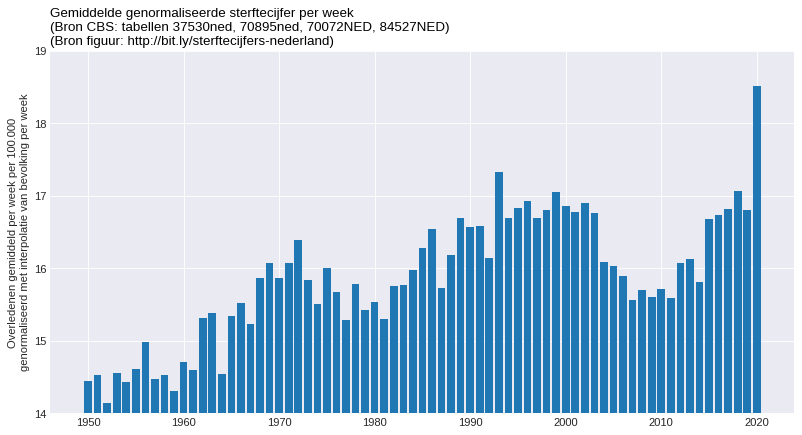

In [11]:
#@title
# Plotting the bar diagram: 1995 till last year
plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
plt.title("Gemiddelde genormaliseerde sterftecijfer per week\n(Bron CBS: tabellen 37530ned, 70895ned, 70072NED, 84527NED)\n(Bron figuur: http://bit.ly/sterftecijfers-nederland)", loc='left', fontsize=12, fontweight=0, color='black')
plt.bar(df_till_last['Jaar'], df_till_last['Gem.per week'])
plt.ylabel("Overledenen gemiddeld per week per 100.000\ngenormaliseerd met interpolatie van bevolking per week")
plt.ylim(14,19)
plt.show()

# Death rate 1995-last year: Jaar, Gem.per week

In [12]:
#@title
df_reference = df_1995_current[df_1995_current['Jaar'] < current_year-1] #2020
# df_other = df_1995_current[df_1995_current['Jaar'] >= current_year -1]
df_other = df_1995_current[(df_1995_current['Jaar'] >= current_year -1) |
                           (df_1995_current['Jaar'] == 1999) | 
                          #  (df_1995_current['Jaar'] == 2015) | 
                           (df_1995_current['Jaar'] == 2018)]
 
 
table_reference = pd.pivot_table(df_reference, values='Overledenen Genormaliseerd', index=['Week'],
                       aggfunc={lambda x: np.percentile(x,75),
                                lambda x: np.percentile(x,50),
                                lambda x: np.percentile(x,25),
                                np.max,
                                np.min})
 
df_all = pd.DataFrame(table_reference.to_records())
df_all = df_all.rename(columns={'amax': 'Max', 'amin': 'Min'})
 
lambda_0 = df_all['<lambda_0>'].iloc[0]
lambda_1 = df_all['<lambda_1>'].iloc[0]
lambda_2 = df_all['<lambda_2>'].iloc[0]
lambda_list = [lambda_0, lambda_1, lambda_2]
 
for x, item in enumerate(lambda_list):
  if item == max(lambda_list):
    df_all.rename(columns={'<lambda_'+str(x)+'>': 'P75'}, inplace=True)
  elif item == min(lambda_list):
    df_all.rename(columns={'<lambda_'+str(x)+'>': 'P25'}, inplace=True)
  else:
    df_all.rename(columns={'<lambda_'+str(x)+'>': 'Mediaan'}, inplace=True)
  
df_all = df_all[['Week', 'Max', 'P75', 'Mediaan', 'P25', 'Min']]
 
table_other = pd.pivot_table(df_other, values='Overledenen Genormaliseerd', columns=['Jaar'], index=['Week'])
df_other = pd.DataFrame(table_other.to_records())
 
# merge
df_all = pd.merge(df_all, df_other, how='left', left_on=['Week'], right_on=['Week'])
headers=['Week', 'Max', 'P75', 'Mediaan', 'P25', 'Min']
for item in df_other.columns:
  if item != 'Week':
    headers.append(item)
print(tabulate(df_all, headers=headers, tablefmt='orgtbl', showindex=False))

|   Week |    Max |    P75 |   Mediaan |     P25 |    Min |    1999 |    2018 |   2020 |    2021 |
|--------+--------+--------+-----------+---------+--------+---------+---------+--------+---------|
|      1 | 22.886 | 19.457 |    18.292 | 17.513  | 16.436 |  19.708 |  19.457 | 17.837 |  23.703 |
|      2 | 21.669 | 19.548 |    18.445 | 17.342  | 16.339 |  19.065 |  19.548 | 19.335 |  22.008 |
|      3 | 20.866 | 19.165 |    18.178 | 16.957  | 15.442 |  18.51  |  19.575 | 18.133 |  22.058 |
|      4 | 21.22  | 19.112 |    18.294 | 16.898  | 15.726 |  18.178 |  19.329 | 17.494 |  21.227 |
|      5 | 20.914 | 19.019 |    18.153 | 17.182  | 16.086 |  18.848 |  19.798 | 18.165 |  20.877 |
|      6 | 20.435 | 19.189 |    17.87  | 16.946  | 16.054 |  19.689 |  20.435 | 18.342 |  20.286 |
|      7 | 21.288 | 18.971 |    17.464 | 16.889  | 15.728 |  19.801 |  21.288 | 18.369 |  20.13  |
|      8 | 21.466 | 19.129 |    18.042 | 17.184  | 15.907 |  19.868 |  21.466 | 16.99  |  18.322 |
|      9 |

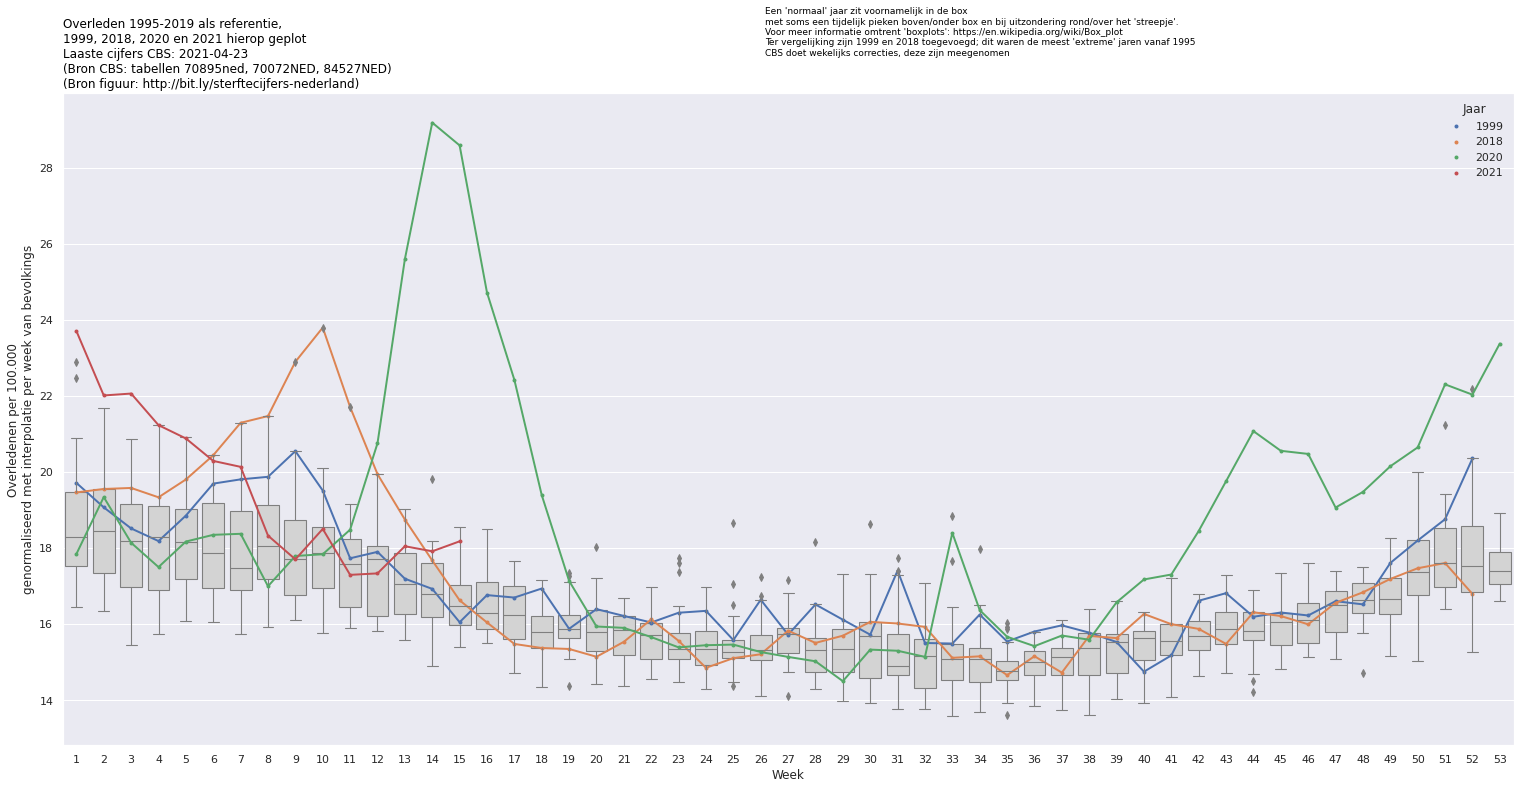

In [13]:
#@title
last_update = cbsodata.get_info('70895ned')['Modified'][0:10]
df_reference1 = df_1995_current[df_1995_current['Jaar'] < current_year-1] #2020
# df_other = df_1995_current[df_1995_current['Jaar'] >= current_year -1]
df_other1 = df_1995_current[(df_1995_current['Jaar'] >= current_year -1) |
                           (df_1995_current['Jaar'] == 1999) | 
                          #  (df_1995_current['Jaar'] == 2015) | 
                           (df_1995_current['Jaar'] == 2018)]
 
sns.set_theme(style='darkgrid', rc={'lines.linewidth': 1.1})
fix, ax = plt.subplots(figsize=[26,12])
sns.pointplot(x='Week', y='Overledenen Genormaliseerd', data=df_other1, ax=ax, hue='Jaar', markers='.')
ax = sns.boxplot(x='Week', y='Overledenen Genormaliseerd', data=df_reference1, color='lightgrey')
plt.title("Overleden 1995-2019 als referentie,\n1999, 2018, 2020 en 2021 hierop geplot\nLaaste cijfers CBS: "+ last_update+"\n(Bron CBS: tabellen 70895ned, 70072NED, 84527NED)\n(Bron figuur: http://bit.ly/sterftecijfers-nederland)", loc='left', fontsize=12, fontweight=0, color='black')
plt.suptitle("Een 'normaal' jaar zit voornamelijk in de box\nmet soms een tijdelijk pieken boven/onder box en bij uitzondering rond/over het 'streepje'.\nVoor meer informatie omtrent 'boxplots': https://en.wikipedia.org/wiki/Box_plot\nTer vergelijking zijn 1999 en 2018 toegevoegd; dit waren de meest 'extreme' jaren vanaf 1995\nCBS doet wekelijks correcties, deze zijn meegenomen", horizontalalignment = 'left', fontsize=9, fontweight=0, color='black')
plt.xlabel("Week")
plt.ylabel("Overledenen per 100.000\ngenormaliseerd met interpolatie per week van bevolkings")
plt.show()